In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer
from sklearn import metrics

import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras import regularizers

import MyKNN as myknn
import MyCNN as mycnn
import Get_Data as get

### Load Dataset 2

In [2]:
data = get.get_data_gcdb()

### Get Data For CNN

In [3]:
X = np.array(list(data.Image))
Y = to_categorical(list(data.Label_id))

### Split Data into Train, Test and Validation Sets

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.15, random_state=42, shuffle=True, stratify=Y)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1275, random_state=42, shuffle=True, stratify=y_train)

In [5]:
train_data = ImageDataGenerator(
    rescale = 1./255,
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    horizontal_flip=True,
    rotation_range=0.2,
    dtype= np.float32
)

train_data.fit(X_train.reshape(len(X_train),40,40,1))

In [6]:
val_data = ImageDataGenerator(
    rescale =1./255,
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    horizontal_flip=True,
    rotation_range=0.2,
    dtype= np.float32
)

val_data.fit(X_val.reshape(len(X_val), 40, 40, 1))

In [7]:
test_data = ImageDataGenerator(
    rescale =1./255,
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    horizontal_flip=True,
    rotation_range=0.2,
    dtype= np.float32
)

test_data.fit(X_test.reshape(len(X_test), 40, 40, 1))

### Fit MyCNN Model

In [8]:
history, model = mycnn.fit_model(X_train, y_train, X_val, y_val, X_test, y_test)

Model Summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 40, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 16)        1168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                     

In [9]:
model.evaluate(X_test, y_test)

219/219 [==============================] - 1s 4ms/step - loss: 0.7641 - accuracy: 0.8844


[0.7640777826309204, 0.8844170570373535]

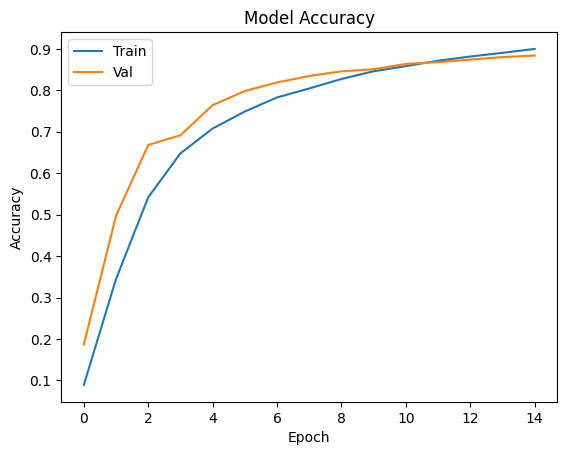

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.show()

### Get data For KNN

In [11]:
images = np.array(list(data.Image))
label = np.array(list(data.Label_id))

In [12]:
images_KNN = np.array(list(map(lambda x : x.flatten(), images)))

In [13]:
_, X_temp_KNN, _, y_temp_KNN = train_test_split(images_KNN, label, test_size=0.1, random_state=42, shuffle=True, stratify=label)

In [14]:
X_train_KNN, X_test_KNN, y_train_KNN, y_test_KNN = train_test_split(X_temp_KNN, y_temp_KNN, test_size=0.20, random_state=42, shuffle=True, stratify=y_temp_KNN)

In [15]:
scaler = Normalizer().fit(X_train_KNN)
X_train_scaled = scaler.transform(X_train_KNN)
X_test_scaled = scaler.transform(X_test_KNN)

### Fit MyKNN Model

Text(0.5, 0, 'Value of k')

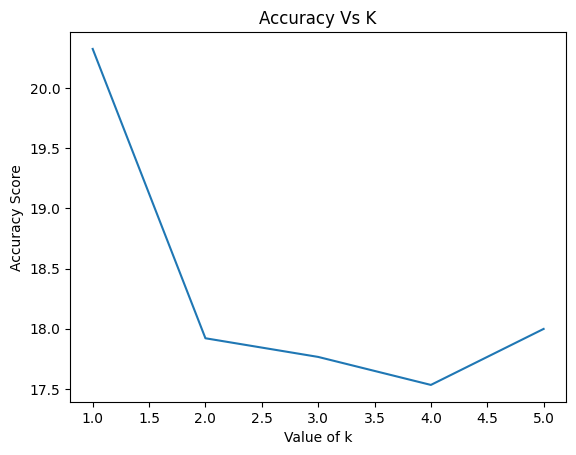

In [16]:
k = list(range(1,6))
accuracy = []
for i in k:
    Y_pred_KNN = myknn.knn_model(X_train_scaled, X_test_scaled, y_train_KNN, i)
    accuracy.append(myknn.calc_accuracy(Y_pred_KNN, y_test_KNN))
plt.plot(k, accuracy)
plt.title("Accuracy Vs K")
plt.ylabel("Accuracy Score")
plt.xlabel("Value of k")

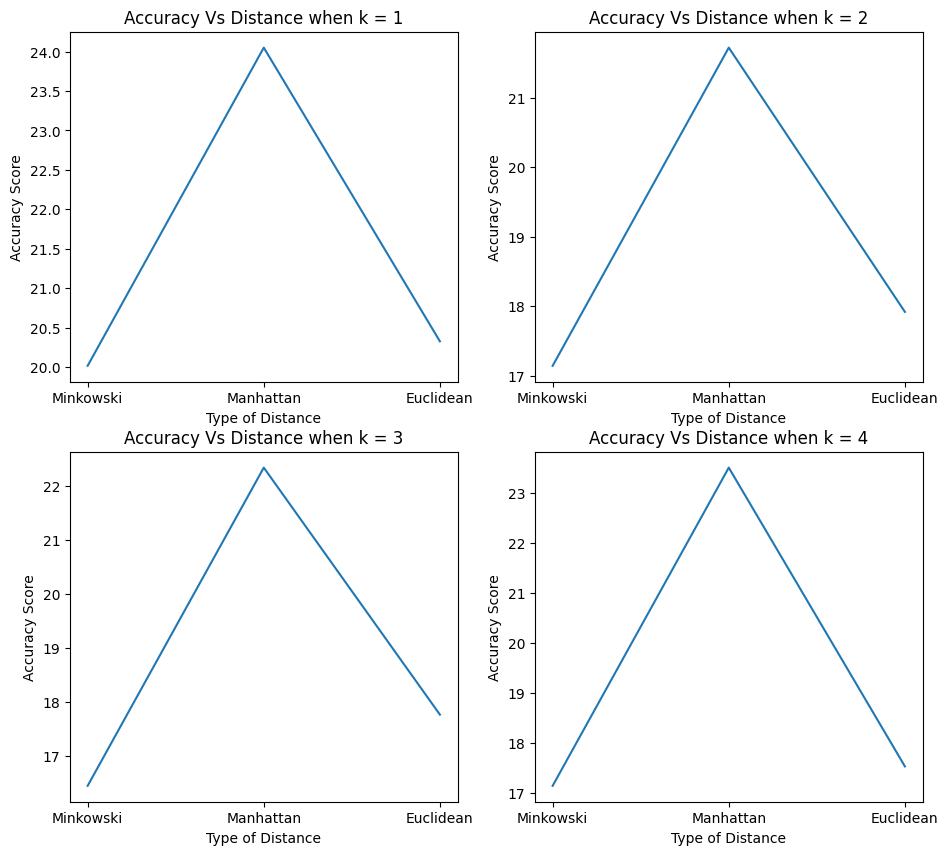

In [17]:
dist_type = ["Minkowski", "Manhattan", "Euclidean"]
accuracy = []
plt.figure(figsize=(11, 10))
for i in range(1,5):
    for d in dist_type:
        Y_pred_KNN = myknn.knn_model(X_train_scaled, X_test_scaled, y_train_KNN, i, d)
        accuracy.append(myknn.calc_accuracy(Y_pred_KNN, y_test_KNN))
    ax = plt.subplot(2, 2, i)
    ax.plot(dist_type, accuracy)
    ax.set_title('Accuracy Vs Distance when k = {}'.format(i))
    ax.set_ylabel("Accuracy Score")
    ax.set_xlabel("Type of Distance")
    accuracy = []

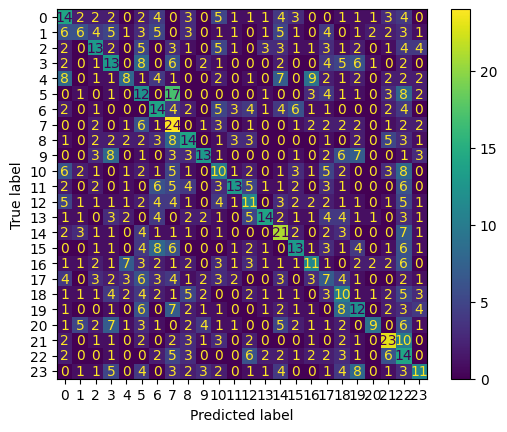

In [19]:
Y_pred = myknn.knn_model(X_train_scaled, X_test_scaled, y_train_KNN, 1, "Manhattan")
confusion_matrix = metrics.confusion_matrix(y_test_KNN, Y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

### Fit SKlearn KNN

In [20]:
accuracy = []
for i in k:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_KNN,y_train_KNN)
    accuracy.append(knn.score(X_test_KNN, y_test_KNN)*100)

Text(0.5, 0, 'Value of k')

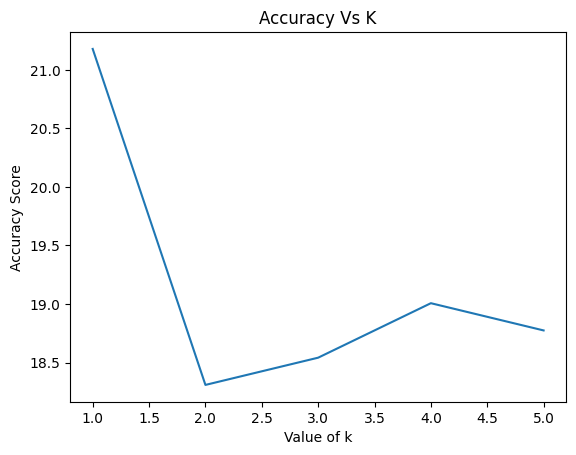

In [21]:
plt.plot(k, accuracy)
plt.title("Accuracy Vs K")
plt.ylabel("Accuracy Score")
plt.xlabel("Value of k")

In [22]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_KNN,y_train_KNN)

KNeighborsClassifier(n_neighbors=1)

In [23]:
y_pred_sk = knn.predict(X_test_KNN)

In [25]:
confusion_matrix = metrics.confusion_matrix(y_test_KNN, y_pred_sk)

In [26]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

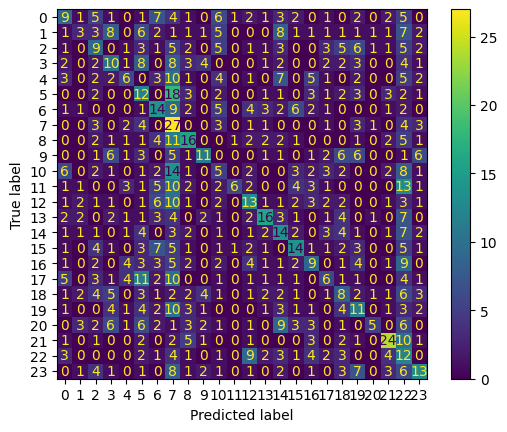

In [27]:
cm_display.plot()
plt.show()